In [1]:
from sklearn.datasets import make_classification,make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, recall_score,f1_score,make_scorer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.datasets import load_breast_cancer
from ucimlrepo import fetch_ucirepo 

In [2]:
#setup the dataset
dataset = 'make_classification' #use sklearn make_classification by default. difficulty depends on class_sep
#dataset = 'moons' #difficult if noise value is high
#dataset = 'breast_cancer' #easy dataset
dataset = 'CDC_diabetes' #difficult dataset, only accumulates about 40% of negatives
#dataset = 'pima' #similar to CDC_diabetes, negative accumulation is about 50%
#dataset = 'tuandromd' #easy dataset; seems to over assign negatives, but final PU model performs well on test holdout

if dataset == 'moons':
    X, y = make_moons(n_samples=40000, shuffle=True, noise=5, random_state=None)
    input_df=pd.DataFrame(X)
    input_df['label']=y
    input_df=pd.concat([input_df[input_df.label == 0].sample(n=16000),input_df[input_df.label == 1].sample(n=4000)]).sample(frac=1).reset_index(drop=True)
    X=input_df.iloc[:,:-1].values
    y=input_df.iloc[:,-1].values
    del input_df
elif dataset == 'breast_cancer':
    X,y=load_breast_cancer(return_X_y=True)
    y=1-y #the dataset currently has benign as 1 and malignant as 0.  Let's switch it
elif dataset == 'pima':
    X=pd.read_csv('pima_diabetes.csv',header=None).iloc[:,:-1].values
    y=pd.read_csv('pima_diabetes.csv',header=None).iloc[:,-1].values
elif dataset == 'make_classification': #create a toy binary classification dataset
    X, y = make_classification(n_samples=20000, flip_y=0, n_features=20, n_informative=4, 
                           n_redundant=5,shuffle=False, weights=[0.8,0.2], class_sep=1)

if dataset == 'CDC_diabetes':
    # fetch dataset 
    cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
      
    # data (as pandas dataframes) 
    X = cdc_diabetes_health_indicators.data.features 
    y = cdc_diabetes_health_indicators.data.targets
    
    input_df=pd.concat([X,y],axis=1)
    input_df=input_df.rename(columns={'Diabetes_binary':'label'})
elif dataset == 'tuandromd':
    # fetch dataset 
    input_df=pd.read_csv('TUANDROMD.csv')
    input_df=input_df.rename(columns={'Label':'label'})
else: #all other datasets have to be put into a dataframe    
    #create the data frame
    input_df=pd.DataFrame(X,columns=[f'feat_{n}' for n in range(X.shape[1])])
    input_df['label']=y

#drop NaN values
df = input_df.dropna().copy()

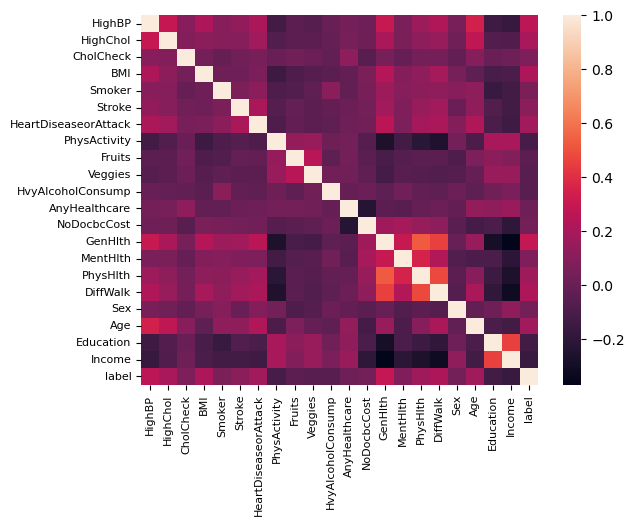

In [3]:
#plot a heatmap of correlation between features
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.heatmap(df.corr())
plt.show()

In [4]:
#create relabel column for tracking
df['relabel']=df.label.values
features=df.shape[1]-2 #-2 for the label and relabel columns

#start printing info about the data split
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(f'Initiail Size of Dataset: {len(input_df)}')
print(f'Size of Dataset after Dropping NaNs: {len(df)}')

#split unlabeled cases and positives for train, spies, and test using 70/10/10 split of positives
ratio=len(df[df.label == 0])/len(df[df.label == 1])
positives_train=int(df[df.label == 1].shape[0]*0.6)
positives_spies=int(df[df.label == 1].shape[0]*0.2)
positives_test=int(df[df.label == 1].shape[0]*0.1)
negatives_test=int(positives_test*ratio)
unlabeled=df[df.label == 0].shape[0] - negatives_test

#use the remaining 10% to mislabel to practically test their recovery
mislabeled=df[df.label == 1].shape[0] - positives_train - positives_spies - positives_test

positives_test=df[df.label == 1].sample(n=positives_test)
df=df.drop(index=positives_test.index)
negatives_test=df[df.label==0].sample(n=negatives_test)
df=df.drop(index=negatives_test.index)
test=pd.concat([positives_test,negatives_test])

#create dataframes
unlabeled=df[df.label == 0].sample(n=unlabeled)
df=df.drop(index=unlabeled.index)
positives_train=df[df.label == 1].sample(n=positives_train)
df=df.drop(index=positives_train.index)
positives_spies=df[df.label == 1].sample(n=positives_spies)
df=df.drop(index=positives_spies.index)

#take the rest of the positives to mislabel them into the unlabeled pool to measure our recovery
mislabeled=df[df.label == 1].sample(n=mislabeled)
df=df.drop(index=mislabeled.index)
mislabeled.loc[mislabeled.label==1,'relabel']=0

#define the entire dataset used in training for later
data=pd.concat([positives_train,positives_spies,unlabeled,mislabeled])

#finish printing info about the data split
print(f'Size of Unlabeled Cases: {len(unlabeled)}')
print(f'Size of Training Positives: {len(positives_train)}')
print(f'Size of Positive Spies: {len(positives_spies)}')
print(f'Size of Test Set: {len(test)}')
print(f'Size of Mislabeled Positives for Recovery: {len(mislabeled)}')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initiail Size of Dataset: 253680
Size of Dataset after Dropping NaNs: 253680
Size of Unlabeled Cases: 196505
Size of Training Positives: 21207
Size of Positive Spies: 7069
Size of Test Set: 25363
Size of Mislabeled Positives for Recovery: 3536
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


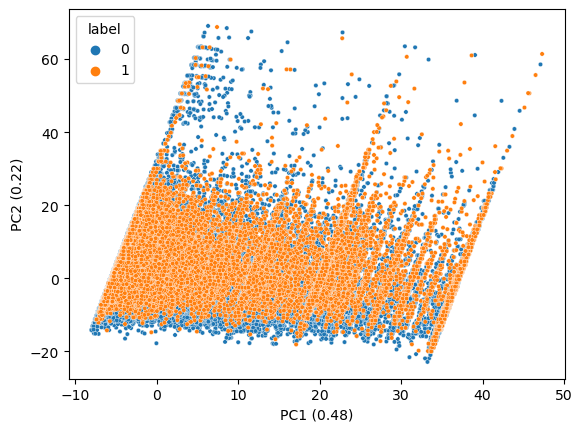

In [5]:
#visualize the dataset with PCA with 2 components
pca=PCA(2)
data[['PC1','PC2']]=pca.fit_transform(data.iloc[:,0:features])
sns.scatterplot(data.sort_values(by=['label']),x='PC1',y='PC2',hue='label',s=10)
plt.xlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0],2)})')
plt.ylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1],2)})')
plt.show()

#drop the PCs as we won't use them
data=data.drop(columns=['PC1','PC2'])

                 feature     value
13               GenHlth  0.266048
0                 HighBP  0.235021
3                    BMI  0.109744
1               HighChol  0.107121
16              DiffWalk  0.081977
18                   Age  0.081554
6   HeartDiseaseorAttack  0.027963
20                Income  0.025356
15              PhysHlth  0.020557
19             Education  0.010491


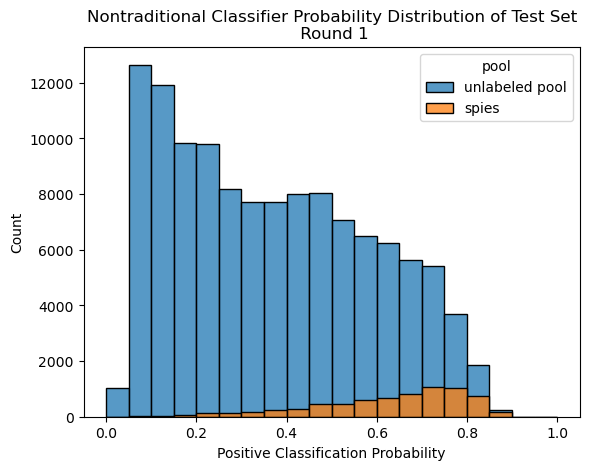

In [6]:
#set some parameters
max_depth= 3 if int(features**0.5) < 3 else int(features**0.5) #depth of each tree in random forest model
n_estimators=100 # number of trees in random forest model
k=1.5 #factor for tukey fence.  1.5 is typical.  3.0 is "way out"

#initiliaze the negatives and their probability
negatives=pd.concat([unlabeled,mislabeled])
negatives['prob']=0
old_idx=set([-1])

#initialize some lists for recording
rounds=[0]
limits=[0.5]
neg_samples=[0]
recoveries=[0]
sims=[0]
min_rounds=rounds[-1]+10

#iteratively remove likely positives from the negative pool
for n in range(rounds[-1]+1,rounds[-1]+101):
    #construct the training set
    #positives=pd.concat([positives_train,positives_spies])
    #positives_train=positives.sample(n=len(positives_train))
    #positives_spies=positives[positives.index.isin(positives_train.index) == False]
    if negatives.shape[0] > 0:
        train=pd.concat([positives_train,negatives.sample(frac=0.5,replace=True)])
    else:
        negatives=pd.concat([negatives,recovered])
        train=pd.concat([positives_train,negatives.sort_values(by=['prob']).head(len(positives_train))])
    
    X_train=train.iloc[:,0:features].values
    y_train=train['relabel'].values
    
    if sims[-1] < 0.99:    
        #hyperparameter tune by grid search
        param_grid = {
            'max_depth': [3] if int(features**0.5) < 3 else list(range(3,2*int(features**0.5))),
        }
        clf=RandomForestClassifier(class_weight="balanced",n_jobs=-1)
        scorer = make_scorer(recall_score, pos_label=0) #optimize toward recalling negatives
        grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, scoring='precision')
        grid_search.fit(X_train,y_train)
        max_depth=grid_search.best_params_['max_depth']
    
    #train the classifier
    clf=RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators,class_weight="balanced",n_jobs=-1)
    clf.fit(X_train, y_train)
    
    #predict on everything
    X_data=data.iloc[:,0:features].values
    y_data=data['relabel'].values
    y_data_prob=clf.predict_proba(X_data)#[:,1]
    y_data_pred=clf.predict(X_data)#np.where(y_spies_prob >= 0.5, 1,0)
    
    #if all the predictions are the same, clf.predict will return an nx1 matrix, so probabilities need adjusted in the case of all negatives
    if y_data_pred.mean() == 0:
        y_data_prob=1-y_data_prob
    else:
        y_data_prob=y_data_prob[:,-1]
    
    data['prob']=y_data_prob
    
    #define each pool
    positives_train=data[data.index.isin(positives_train.index)]
    positives_spies=data[data.index.isin(positives_spies.index)]
    y_spies=positives_spies.label.values
    
    #use a Tukey fence to set the lower limit from known positives
    IQR=positives_spies.prob.quantile(0.75)-positives_spies.prob.quantile(0.25)
    pos_limit=positives_spies.prob.quantile(0.25)-k*IQR
        
    #assign the prediction labels based on the pos_limit
    y_data_pred=np.where(y_data_prob >= pos_limit, 1,0)
    data['pred']=y_data_pred
    
    #define each pool, just to get the spies predictions
    positives_train=data[data.index.isin(positives_train.index)]
    positives_spies=data[data.index.isin(positives_spies.index)]
    y_spies=positives_spies.label.values
    y_spies_pred=positives_spies.pred.values
    
    #look at the probabilities from the initial nontraditional classifier probabilities in the unlabeled pool
    #and the feature importance
    if n == 1:
        #feature importance
        importance=pd.DataFrame(data.columns[0:features],columns=['feature'])
        importance['value']=clf.feature_importances_
        importance=importance.sort_values(by=['value'], ascending=False)
        print(importance[importance.value >= 0.01])
        
        #summarize findings
        sns.histplot(data[(data.relabel == 0) & (data.index.isin(train.index)==False) & (data.index.isin(positives_spies.index)==False)],x='prob',label='unlabeled pool',binwidth=0.05,binrange=[0,1])
        sns.histplot(data[data.index.isin(positives_spies.index)],x='prob',label='spies',binwidth=0.05,binrange=[0,1])
        plt.legend(title='pool')
        plt.ylabel('Count')
        plt.xlabel('Positive Classification Probability')
        plt.title(f'Nontraditional Classifier Probability Distribution of Test Set\n Round {n}')
        plt.show()

    #separate recovered positives and negatives based on the tukey fence
    recovered=data[(data.relabel == 0) & (data.prob >= pos_limit)]
    negatives=data[(data.relabel == 0) & (data.prob < pos_limit)]
    
    #calculate the recovery of mislabeled positives
    recovery=recovered[recovered.label == 1].shape[0]/mislabeled.shape[0]
    recoveries.append(recovery)
    
    # record a few things
    neg_samples.append(negatives.shape[0])
    rounds.append(n)
    limits.append(pos_limit)
    
    #we can add in similarity to negative indices from the previous round and the current round
    #this would ensure we are converging not just on the same number of negatives, but the same negatives themselves
    #https://www.geeksforgeeks.org/python-percentage-similarity-of-lists/
    new_idx=set(negatives.index.tolist())
    common_elements=new_idx.intersection(old_idx)
    num_common_elements = len(common_elements)
    total_elements = set(old_idx).union(new_idx)
    num_total_elements = len(total_elements)
    neg_set_sim = (num_common_elements / num_total_elements)
    sims.append(neg_set_sim)
    old_idx=set(negatives.index.tolist())
    
    # we need to iterate at least three rounds to calculate derivatives by difference formulas
    if n < 3:
        continue

    #break if a couple metrics converge according to the relative slope at the last point
    #a very small number is added to the denominator to prevent division by zero
    negs_change=abs((neg_samples[-3]-4*neg_samples[-2]+3*neg_samples[-1])/2/(neg_samples[-1]+0.0000001))
    sim_change=abs((sims[-3]-4*sims[-2]+3*sims[-1])/2/(sims[-1]+0.0000001))
    recovery_change=abs((recoveries[-3]-4*recoveries[-2]+3*recoveries[-1])/2/(recoveries[-1]+0.0000001))
    limits_change=abs((limits[-3]-4*limits[-2]+3*limits[-1])/2/(limits[-1]+0.0000001))
    #print(negs_change,sim_change,limits_change)
    
    if negs_change < 0.01 and sim_change < 0.05 and n >= min_rounds:# and recovery_change < 0.05 and limits_change < 0.025
        break

In [7]:
#show classification reports on training and spies set
#print('Training Set\n',classification_report(y_train,y_train_pred,zero_division=0.0))
print('Spies Set\n',classification_report(y_spies,y_spies_pred,zero_division=0.0))

Spies Set
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.88      0.94      7069

    accuracy                           0.88      7069
   macro avg       0.50      0.44      0.47      7069
weighted avg       1.00      0.88      0.94      7069



In [8]:
#estimate the recovery of the final PU model
#it should be roughly the ratio of reliable negatives in the training set to the total number of unlabeled data points
ANR=negatives.shape[0]/unlabeled.shape[0] #data[data.relabel == 0].shape[0]
ANR=np.round(ANR,3)
print(f'PU Model Negative Recall ≈  Assigned Negatives Ratio = {ANR}')

PU Model Negative Recall ≈  Assigned Negatives Ratio = 0.567


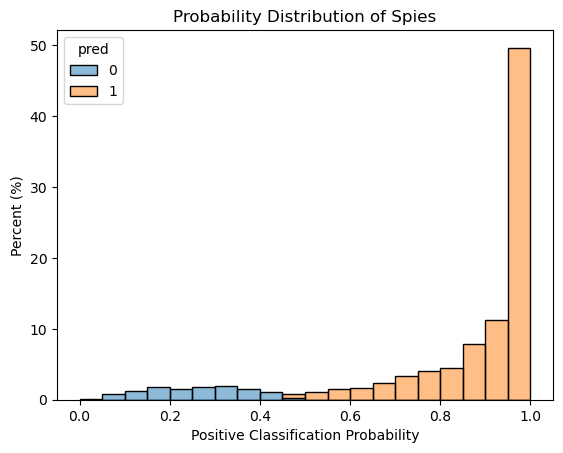

In [9]:
sns.histplot(positives_spies,x='prob',hue='pred',binwidth=0.05,common_norm=True,stat='percent',binrange=[0,1])
plt.ylim(0,)
plt.ylabel('Percent (%)')
plt.xlabel('Positive Classification Probability')
plt.title('Probability Distribution of Spies')
plt.show()

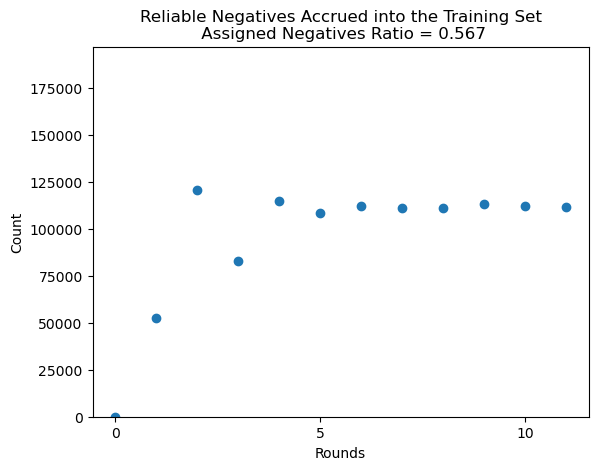

In [10]:
plt.scatter(rounds,neg_samples)
plt.ylim(0,max(max(neg_samples),unlabeled.shape[0]))
plt.xticks(range(0,len(rounds),5))
plt.xlabel('Rounds')
plt.ylabel('Count')
plt.title(f'Reliable Negatives Accrued into the Training Set\n Assigned Negatives Ratio = {ANR}')
plt.show()

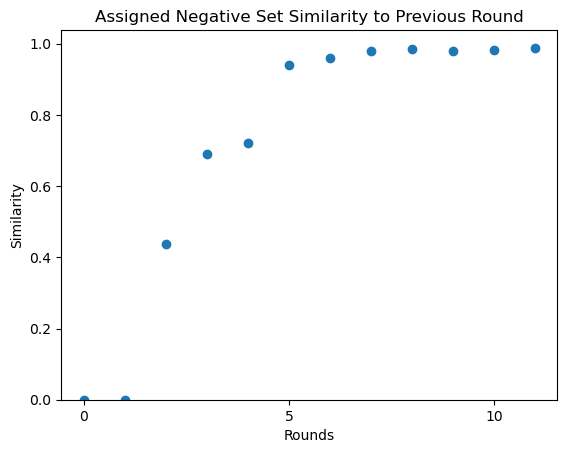

In [11]:
plt.scatter(rounds,sims)
plt.ylim(0,)
plt.xticks(range(0,len(rounds),5))
plt.xlabel('Rounds')
plt.ylabel('Similarity')
plt.title(f'Assigned Negative Set Similarity to Previous Round')
plt.show()

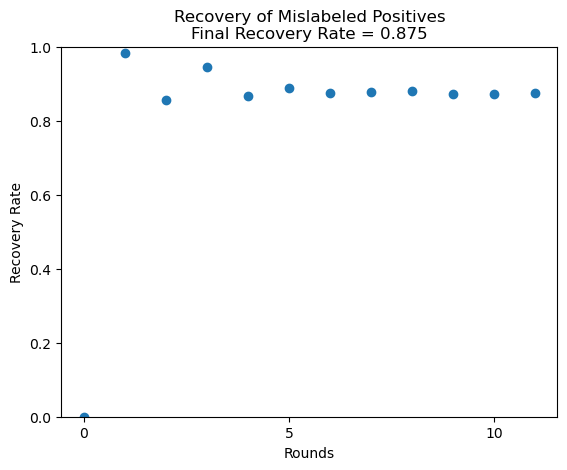

In [12]:
plt.scatter(rounds,recoveries)
plt.ylim(0,1)
plt.xticks(range(0,len(rounds),5))
plt.xlabel('Rounds')
plt.ylabel('Recovery Rate')
plt.title(f'Recovery of Mislabeled Positives\nFinal Recovery Rate = {np.round(recoveries[-1],3)}')
plt.show()

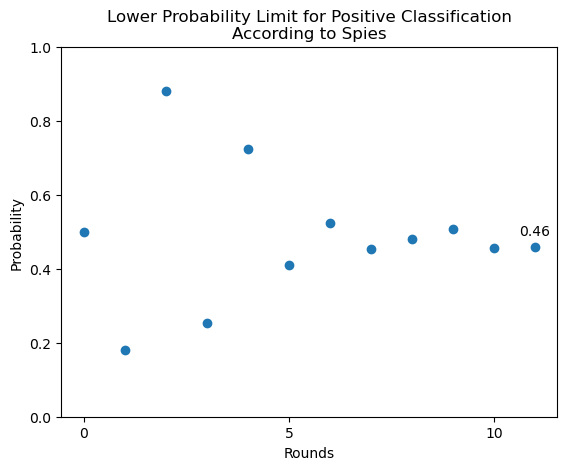

In [13]:
plt.scatter(rounds,limits)
plt.ylim(0,1)
plt.xticks(range(0,len(rounds),5))
plt.xlabel('Rounds')
plt.ylabel('Probability')
plt.title('Lower Probability Limit for Positive Classification\nAccording to Spies')
plt.text(rounds[-1],limits[-1]+.03,f'{np.round(limits[-1],2)}',horizontalalignment='center')
plt.show()

In [14]:
#calculate an enrichment factor for mislabeled positives recovered compared to all the mislabeled positives in all the unlabeled data
EF=recovered[recovered.label == 1].shape[0]/recovered.shape[0]/(mislabeled.shape[0]/(mislabeled.shape[0]+unlabeled.shape[0]))
print(f'Enrichment Factor = {np.round(EF,2)}')

Enrichment Factor = 1.98


Training Set
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    111414
           1       0.99      0.87      0.93     28276

    accuracy                           0.97    139690
   macro avg       0.98      0.93      0.95    139690
weighted avg       0.97      0.97      0.97    139690

Test Set
               precision    recall  f1-score   support

           0       0.96      0.57      0.71     21829
           1       0.25      0.87      0.38      3534

    accuracy                           0.61     25363
   macro avg       0.61      0.72      0.55     25363
weighted avg       0.86      0.61      0.67     25363



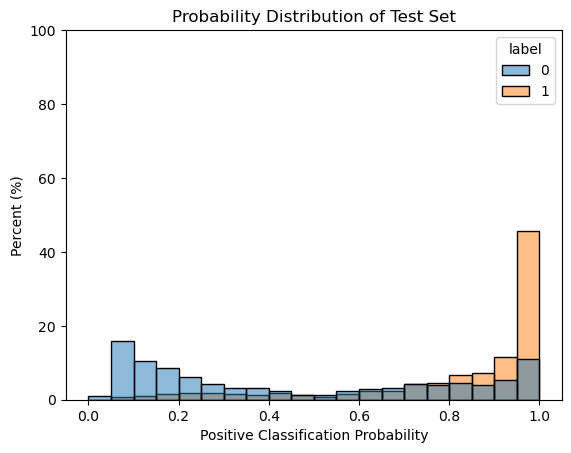

In [15]:
#train the final model on the final set of negatives and positive training samples
train=pd.concat([positives_train,positives_spies,negatives])
X_train=train.iloc[:,0:features].values
y_train=train['relabel'].values #since all unlabeled samples were originally assigned a 0 for their labe, we use the label value here

#hyperparameter tune by grid search
param_grid = {
    'max_depth': [3] if int(features**0.5) < 3 else list(range(3,2*int(features**0.5))),
}
clf=RandomForestClassifier(class_weight="balanced",n_jobs=-1)
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1,scoring='precision')
grid_search.fit(X_train,y_train)
max_depth=grid_search.best_params_['max_depth']

#fit the final classifier
clf=RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators,class_weight="balanced",n_jobs=-1)
clf.fit(X_train, y_train)
y_train_pred=clf.predict(X_train)
print('Training Set\n',classification_report(y_train,y_train_pred))

#run the classifier on the final test set
X_test=test.iloc[:,0:features].values
y_test=test['label'].values
y_test_prob=clf.predict_proba(X_test)#[:,1]
y_test_pred=clf.predict(X_test)#np.where(y_test_prob >= 0.5, 1,0)

#if all the predictions are the same, clf.predict will return an nx1 matrix, so probabilities need adjusted in the case of all negatives
if y_test_pred.mean() == 0:
    y_test_prob=1-y_test_prob
else:
    y_test_prob=y_test_prob[:,-1]

test['prob']=y_test_prob
#y_test_pred=np.where(y_test_prob >= limits[-1], 1,0)

#summarize findings
print('Test Set\n',classification_report(y_test,y_test_pred,zero_division=0.0))
sns.histplot(test,x='prob',hue='label',binwidth=0.05,common_norm=False,stat='percent',binrange=[0,1])
plt.ylim(0,100)
plt.ylabel('Percent (%)')
plt.xlabel('Positive Classification Probability')
plt.title('Probability Distribution of Test Set')
plt.show()

In [16]:
#examine feature importance according to the model
importance_PU=pd.DataFrame(data.columns[0:features],columns=['feature'])
importance_PU['value']=clf.feature_importances_
importance_PU=importance_PU.sort_values(by=['value'], ascending=False)
print(importance_PU[importance_PU.value >= 0.01])

                 feature     value
0                 HighBP  0.348890
13               GenHlth  0.214575
1               HighChol  0.106500
16              DiffWalk  0.097847
18                   Age  0.084782
3                    BMI  0.055163
6   HeartDiseaseorAttack  0.027549
15              PhysHlth  0.024805
20                Income  0.023574


Training Set
               precision    recall  f1-score   support

           0       0.95      0.71      0.81    196505
           1       0.31      0.79      0.44     31812

    accuracy                           0.72    228317
   macro avg       0.63      0.75      0.63    228317
weighted avg       0.86      0.72      0.76    228317

Test Set
               precision    recall  f1-score   support

           0       0.95      0.70      0.81     21829
           1       0.30      0.79      0.44      3534

    accuracy                           0.72     25363
   macro avg       0.63      0.75      0.62     25363
weighted avg       0.86      0.72      0.76     25363



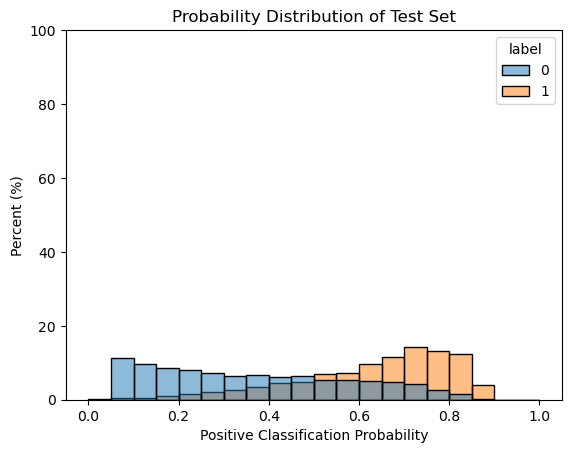

In [17]:
#get a baseline on traditional supervised learning
#remake the training dataset and train using the correct labels
train_baseline=pd.concat([positives_train,positives_spies,mislabeled,unlabeled])
X_train_baseline=train_baseline.iloc[:,0:features].values
y_train_baseline=train_baseline['label'].values

#hyperparameter tune by grid search
param_grid = {
    'max_depth': [3] if int(features**0.5) < 3 else list(range(3,2*int(features**0.5))),
}
clf3=RandomForestClassifier(class_weight="balanced",n_jobs=-1)
grid_search = GridSearchCV(estimator = clf3, param_grid = param_grid, cv = 3, n_jobs = -1, scoring='precision')
grid_search.fit(X_train_baseline,y_train_baseline)
max_depth=grid_search.best_params_['max_depth']

#fit the final classifier
clf3=RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators,class_weight="balanced",n_jobs=-1)
clf3.fit(X_train_baseline, y_train_baseline)
y_train_pred=clf3.predict(X_train_baseline)
print('Training Set\n',classification_report(y_train_baseline,y_train_pred))

#run the classifier on the final test set
X_test=test.iloc[:,0:features].values
y_test=test['label'].values
y_test_prob=clf3.predict_proba(X_test)#[:,1]
y_test_pred=clf3.predict(X_test)#np.where(y_test_prob >= 0.5, 1,0)

#if all the predictions are the same, clf.predict will return an nx1 matrix, so probabilities need adjusted in the case of all negatives
if y_test_pred.mean() == 0:
    y_test_prob=1-y_test_prob
else:
    y_test_prob=y_test_prob[:,-1]

test['prob']=y_test_prob

#summarize findings
print('Test Set\n',classification_report(y_test,y_test_pred,zero_division=0.0))
sns.histplot(test,x='prob',hue='label',binwidth=0.05,common_norm=False,stat='percent',binrange=[0,1])
plt.ylim(0,100)
plt.ylabel('Percent (%)')
plt.xlabel('Positive Classification Probability')
plt.title('Probability Distribution of Test Set')
plt.show()

In [18]:
#examine feature importance according to the baseline model
importance_baseline=pd.DataFrame(data.columns[0:features],columns=['feature'])
importance_baseline['value']=clf3.feature_importances_
importance_baseline=importance_baseline.sort_values(by=['value'], ascending=False)
print(importance_baseline[importance_baseline.value >= 0.01])

                 feature     value
13               GenHlth  0.268264
0                 HighBP  0.215013
3                    BMI  0.140637
1               HighChol  0.097454
18                   Age  0.090220
16              DiffWalk  0.068611
6   HeartDiseaseorAttack  0.032600
20                Income  0.029462
15              PhysHlth  0.020677


In [19]:
#calculate the the similarity in features between PU and baseline model
importance_limit=0.01
feat_PU=set(importance_PU[importance_PU.value >= importance_limit].feature.tolist())
feat_baseline=set(importance_baseline[importance_baseline.value >= importance_limit].feature.tolist())
common_elements=feat_PU.intersection(feat_baseline)
num_common_elements = len(common_elements)
total_elements = set(feat_PU).union(feat_baseline)
num_total_elements = len(total_elements)
feat_sim = np.round((num_common_elements / num_total_elements),2)
print(f'PU and baseline models share a feature similarity of {feat_sim}\nfor features with importance >= {importance_limit}')

PU and baseline models share a feature similarity of 1.0
for features with importance >= 0.01
